In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plant import plant
from Standardize import *

In [2]:
def RTRN(W, Y, U, print_weights=True):        
    
    """Common model for both RTRNs; 
    takes standardised input and provides standardised output."""
    
    W1 = W[:, :5]                
    W2 = W[:, 5:] 
    if print_weights:
        print("W:\n")
        print(W, "\n")
    Z = np.dot(W1, Y) + np.dot(W2, U)
    output = np.tanh(Z)          #for tanh activation
    return output

def c_inverse(W, x, delta):             
    
    """Calculates a quantity used in the update_weights function."""
    
    ji = np.dot(W, x) 
    ji_ = 1 - np.tanh(ji)**2     #derivative of  tanh activation
    ji_ = ji_.reshape(-1,)
    c = np.diag(ji_)             
    delta = np.eye(5) * delta
    c += delta                   #small delta is used to prevent singular matrices
    c_inv = np.linalg.inv(c)        
    return c_inv

def U_control(W, W_star, Y_d, Y_next, U):            
    
    """Control law; approximates the system output to the desired output.
    Updates only the 2 control inputs U1 and U2."""
    
    W1 = W[:, :5]                
    W2 = W[:, 5:] 
    W1_star = W_star[:, :5]
    W2_star = W_star[:, 5:]
    W2_g = np.linalg.pinv(W2)
    Z = np.dot(W1_star, Y_d) - np.dot(W1, Y_next) + np.dot(W2_star, U)
    U_star = np.dot(W2_g, Z)
    return U_star


def update_weights(W_old, Y, D, Y_next, delta):                
    
    """Learning algorithm of both the RTRNs."""
    
    c_inv = c_inverse(W_old, Y, delta)                         #small delta is used 
    e1 = (D - Y_next)                                          
    e2 = np.linalg.inv(np.dot(Y.T, Y))
    e2 = np.dot(e2, Y.T)
    e = np.dot(e1, e2)
    W_new = W_old + np.dot(c_inv, e)
    return W_new

In [3]:
def plot_errors(Errors):
    
    """Used for error plots."""
    
    plt.xlabel("Timesteps", fontsize=50)
    plt.ylabel("Error", fontsize=50)
    plt.axhline(y=0, color='r', linestyle='-', lw=10)
    plt.plot(Errors, linewidth=5, color='k')
    plt.tick_params(axis='both', which='major', labelsize=45)

In [4]:
def plot_outputs(P, j, desired_value, print_values=False):
    
    """Plots a particular output of the plant."""
    
    P = np.array(P)
    P = P.flatten().reshape(P.shape[0],5)
    if print_values: print(P[:,  j])    #for printing the values
    plt.xlabel("Timesteps", fontsize=25)
    plt.ylabel("Value", fontsize=25)
    plt.axhline(y=desired_value, color='r', linestyle='-', lw=4)
    plt.plot(P[:,  j], linewidth=2.5)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.title("Plant Output {}".format(j + 1), fontsize=30, loc='center')

In [5]:
#TRAINING CELL
#THE RESULTS ARE SENSITIVE TO INITIAL WEIGHTS

np.random.seed(39)

Plant = plant()                       #creating an object of the plant class

z = df.sample(1)
timesteps = 1000

W = np.random.random((5,7))           #initial weights for RTRN1
W_star = np.random.random((5,7))      #initial weights for RTRN2

x = np.array(z.iloc[0 ,:7])
x = pd.to_numeric(x)
x = x.reshape(7, 1)
X = standardise(x)
RTRN1_input = RTRN2_input = X

Plant_outputs = []
Errors1 = []
Errors2 = []

for t in range(timesteps):
    
    
    Y1 = RTRN1_input[:5]
    Y2 = RTRN2_input[:5]
    U = RTRN1_input[5:]
    x = reverse_standardise(RTRN1_input)
    itr = 0
    
    
    ####################################
    while True:         #RTRN1 do-while                             
        itr += 1
        
        RTRN1_output = RTRN(W, Y1, U, print_weights=False)                            
        x = x.reshape(-1,)
        
        Plant_output = Plant.Predict(x)                            
        Plant_output = Plant_output.reshape(5,1)
        Plant_output_std = standardise(Plant_output, 'y')                       
        
        W = update_weights(W, RTRN1_input, Plant_output_std, RTRN1_output, 0.2)       
        
        e = np.sum(np.square(Plant_output_std - RTRN1_output), axis=0) / 2
        if(e < 1):
            break
    ####################################    
    
    char = "RTRN1"
    print("Timestep {0} has {1} {2} iteration(s)".format(t+1, itr, char)) 
    
    itr = 0    
    
    
    ####################################
    while True:         #RTRN2 do-while
        itr += 1
        
        RTRN2_output = RTRN(W_star, Y2, U, print_weights=False)   
        RTRN2_output_rev_std = reverse_standardise(RTRN2_output, 'y')
        
        Desired_output = np.array([140, 0.5, RTRN2_output_rev_std[2], 
                                   RTRN2_output_rev_std[3], RTRN2_output_rev_std[4]])        
        Desired_output = Desired_output.reshape(5,1)
        Desired_output_std = standardise(Desired_output, 'y')
        
        W_star = update_weights(W_star, RTRN2_input, Desired_output_std, RTRN2_output, 0.2)        
        
        e = np.sum(np.square(Desired_output_std - RTRN2_output), axis=0) / 2
        if(e < 0.1):
            break
    ####################################        

    char = "RTRN2"
    print("Timestep {0} has {1} {2} iteration(s)".format(t+1, itr, char)) 
    
    
    U = U_control(W, W_star, RTRN2_output, RTRN1_output, U)
    
    RTRN1_input[:5] = RTRN1_output
    RTRN1_input[5:] = U
    RTRN2_input[:5] = RTRN2_output
    RTRN2_input[5:] = U
    
    Desired = [140, 0.5]
    
    Plant_outputs.append(Plant_output)
    Errors1.append(Desired[0] - Plant_output[0])
    Errors2.append(Desired[1] - Plant_output[1])
    
    print("\n END OF TIMESTEP {}".format(t+1))
    print(40*"#","\n\n")

Timestep 1 has 2 RTRN1 iteration(s)
Timestep 1 has 2 RTRN2 iteration(s)

 END OF TIMESTEP 1
######################################## 


Timestep 2 has 2 RTRN1 iteration(s)
Timestep 2 has 3 RTRN2 iteration(s)

 END OF TIMESTEP 2
######################################## 


Timestep 3 has 2 RTRN1 iteration(s)
Timestep 3 has 3 RTRN2 iteration(s)

 END OF TIMESTEP 3
######################################## 


Timestep 4 has 2 RTRN1 iteration(s)
Timestep 4 has 2 RTRN2 iteration(s)

 END OF TIMESTEP 4
######################################## 


Timestep 5 has 1 RTRN1 iteration(s)
Timestep 5 has 2 RTRN2 iteration(s)

 END OF TIMESTEP 5
######################################## 


Timestep 6 has 1 RTRN1 iteration(s)
Timestep 6 has 2 RTRN2 iteration(s)

 END OF TIMESTEP 6
######################################## 


Timestep 7 has 1 RTRN1 iteration(s)
Timestep 7 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 7
######################################## 


Timestep 8 has 1 RTRN1 iteration(s)
Timestep 8 h


 END OF TIMESTEP 102
######################################## 


Timestep 103 has 1 RTRN1 iteration(s)
Timestep 103 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 103
######################################## 


Timestep 104 has 1 RTRN1 iteration(s)
Timestep 104 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 104
######################################## 


Timestep 105 has 1 RTRN1 iteration(s)
Timestep 105 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 105
######################################## 


Timestep 106 has 1 RTRN1 iteration(s)
Timestep 106 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 106
######################################## 


Timestep 107 has 1 RTRN1 iteration(s)
Timestep 107 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 107
######################################## 


Timestep 108 has 1 RTRN1 iteration(s)
Timestep 108 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 108
######################################## 


Timestep 109 has 1 RTRN1 iteration(s)
Timestep 109 has 1 RTRN2 iteration(s)

 END 

Timestep 209 has 1 RTRN1 iteration(s)
Timestep 209 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 209
######################################## 


Timestep 210 has 1 RTRN1 iteration(s)
Timestep 210 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 210
######################################## 


Timestep 211 has 1 RTRN1 iteration(s)
Timestep 211 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 211
######################################## 


Timestep 212 has 1 RTRN1 iteration(s)
Timestep 212 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 212
######################################## 


Timestep 213 has 1 RTRN1 iteration(s)
Timestep 213 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 213
######################################## 


Timestep 214 has 1 RTRN1 iteration(s)
Timestep 214 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 214
######################################## 


Timestep 215 has 1 RTRN1 iteration(s)
Timestep 215 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 215
######################################## 


Timest

Timestep 304 has 1 RTRN1 iteration(s)
Timestep 304 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 304
######################################## 


Timestep 305 has 1 RTRN1 iteration(s)
Timestep 305 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 305
######################################## 


Timestep 306 has 1 RTRN1 iteration(s)
Timestep 306 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 306
######################################## 


Timestep 307 has 1 RTRN1 iteration(s)
Timestep 307 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 307
######################################## 


Timestep 308 has 1 RTRN1 iteration(s)
Timestep 308 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 308
######################################## 


Timestep 309 has 1 RTRN1 iteration(s)
Timestep 309 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 309
######################################## 


Timestep 310 has 1 RTRN1 iteration(s)
Timestep 310 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 310
######################################## 


Timest

Timestep 399 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 399
######################################## 


Timestep 400 has 1 RTRN1 iteration(s)
Timestep 400 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 400
######################################## 


Timestep 401 has 1 RTRN1 iteration(s)
Timestep 401 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 401
######################################## 


Timestep 402 has 1 RTRN1 iteration(s)
Timestep 402 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 402
######################################## 


Timestep 403 has 1 RTRN1 iteration(s)
Timestep 403 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 403
######################################## 


Timestep 404 has 1 RTRN1 iteration(s)
Timestep 404 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 404
######################################## 


Timestep 405 has 1 RTRN1 iteration(s)
Timestep 405 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 405
######################################## 


Timestep 406 has 1 RTRN1 iteration(s)
Timest

Timestep 493 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 493
######################################## 


Timestep 494 has 1 RTRN1 iteration(s)
Timestep 494 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 494
######################################## 


Timestep 495 has 1 RTRN1 iteration(s)
Timestep 495 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 495
######################################## 


Timestep 496 has 1 RTRN1 iteration(s)
Timestep 496 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 496
######################################## 


Timestep 497 has 1 RTRN1 iteration(s)
Timestep 497 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 497
######################################## 


Timestep 498 has 1 RTRN1 iteration(s)
Timestep 498 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 498
######################################## 


Timestep 499 has 1 RTRN1 iteration(s)
Timestep 499 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 499
######################################## 


Timestep 500 has 1 RTRN1 iteration(s)
Timest

Timestep 593 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 593
######################################## 


Timestep 594 has 1 RTRN1 iteration(s)
Timestep 594 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 594
######################################## 


Timestep 595 has 1 RTRN1 iteration(s)
Timestep 595 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 595
######################################## 


Timestep 596 has 1 RTRN1 iteration(s)
Timestep 596 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 596
######################################## 


Timestep 597 has 1 RTRN1 iteration(s)
Timestep 597 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 597
######################################## 


Timestep 598 has 1 RTRN1 iteration(s)
Timestep 598 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 598
######################################## 


Timestep 599 has 1 RTRN1 iteration(s)
Timestep 599 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 599
######################################## 


Timestep 600 has 1 RTRN1 iteration(s)
Timest

Timestep 693 has 1 RTRN1 iteration(s)
Timestep 693 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 693
######################################## 


Timestep 694 has 1 RTRN1 iteration(s)
Timestep 694 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 694
######################################## 


Timestep 695 has 1 RTRN1 iteration(s)
Timestep 695 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 695
######################################## 


Timestep 696 has 1 RTRN1 iteration(s)
Timestep 696 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 696
######################################## 


Timestep 697 has 1 RTRN1 iteration(s)
Timestep 697 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 697
######################################## 


Timestep 698 has 1 RTRN1 iteration(s)
Timestep 698 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 698
######################################## 


Timestep 699 has 1 RTRN1 iteration(s)
Timestep 699 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 699
######################################## 


Timest

Timestep 793 has 1 RTRN1 iteration(s)
Timestep 793 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 793
######################################## 


Timestep 794 has 1 RTRN1 iteration(s)
Timestep 794 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 794
######################################## 


Timestep 795 has 1 RTRN1 iteration(s)
Timestep 795 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 795
######################################## 


Timestep 796 has 1 RTRN1 iteration(s)
Timestep 796 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 796
######################################## 


Timestep 797 has 1 RTRN1 iteration(s)
Timestep 797 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 797
######################################## 


Timestep 798 has 1 RTRN1 iteration(s)
Timestep 798 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 798
######################################## 


Timestep 799 has 1 RTRN1 iteration(s)
Timestep 799 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 799
######################################## 


Timest

Timestep 867 has 1 RTRN1 iteration(s)
Timestep 867 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 867
######################################## 


Timestep 868 has 1 RTRN1 iteration(s)
Timestep 868 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 868
######################################## 


Timestep 869 has 1 RTRN1 iteration(s)
Timestep 869 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 869
######################################## 


Timestep 870 has 1 RTRN1 iteration(s)
Timestep 870 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 870
######################################## 


Timestep 871 has 1 RTRN1 iteration(s)
Timestep 871 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 871
######################################## 


Timestep 872 has 1 RTRN1 iteration(s)
Timestep 872 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 872
######################################## 


Timestep 873 has 1 RTRN1 iteration(s)
Timestep 873 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 873
######################################## 


Timest


 END OF TIMESTEP 969
######################################## 


Timestep 970 has 1 RTRN1 iteration(s)
Timestep 970 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 970
######################################## 


Timestep 971 has 1 RTRN1 iteration(s)
Timestep 971 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 971
######################################## 


Timestep 972 has 1 RTRN1 iteration(s)
Timestep 972 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 972
######################################## 


Timestep 973 has 1 RTRN1 iteration(s)
Timestep 973 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 973
######################################## 


Timestep 974 has 1 RTRN1 iteration(s)
Timestep 974 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 974
######################################## 


Timestep 975 has 1 RTRN1 iteration(s)
Timestep 975 has 1 RTRN2 iteration(s)

 END OF TIMESTEP 975
######################################## 


Timestep 976 has 1 RTRN1 iteration(s)
Timestep 976 has 1 RTRN2 iteration(s)

 END 

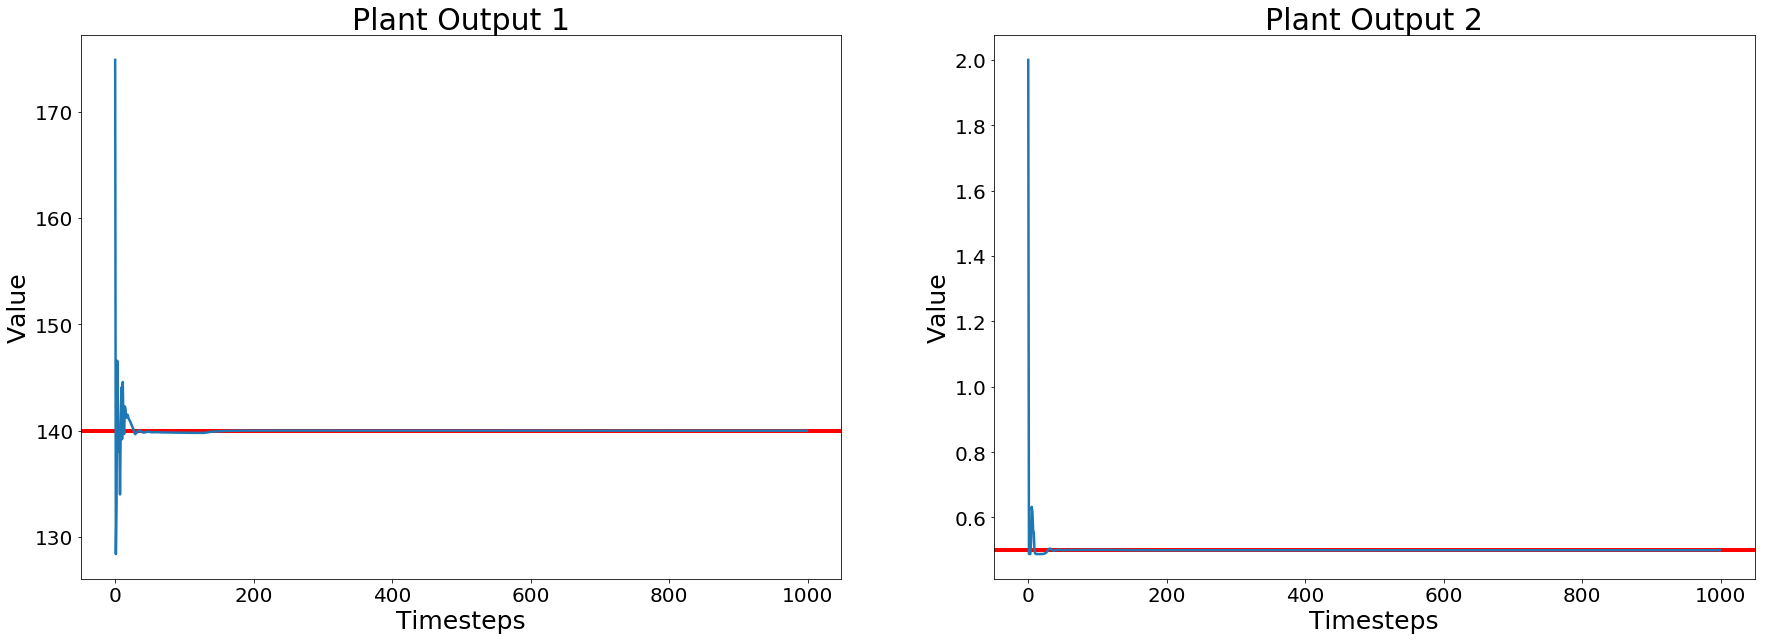

In [6]:
#PLOTTING OUTPUTS
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plot_outputs(Plant_outputs, 0, 140)
plt.subplot(1, 2, 2)
plot_outputs(Plant_outputs, 1, 0.5)

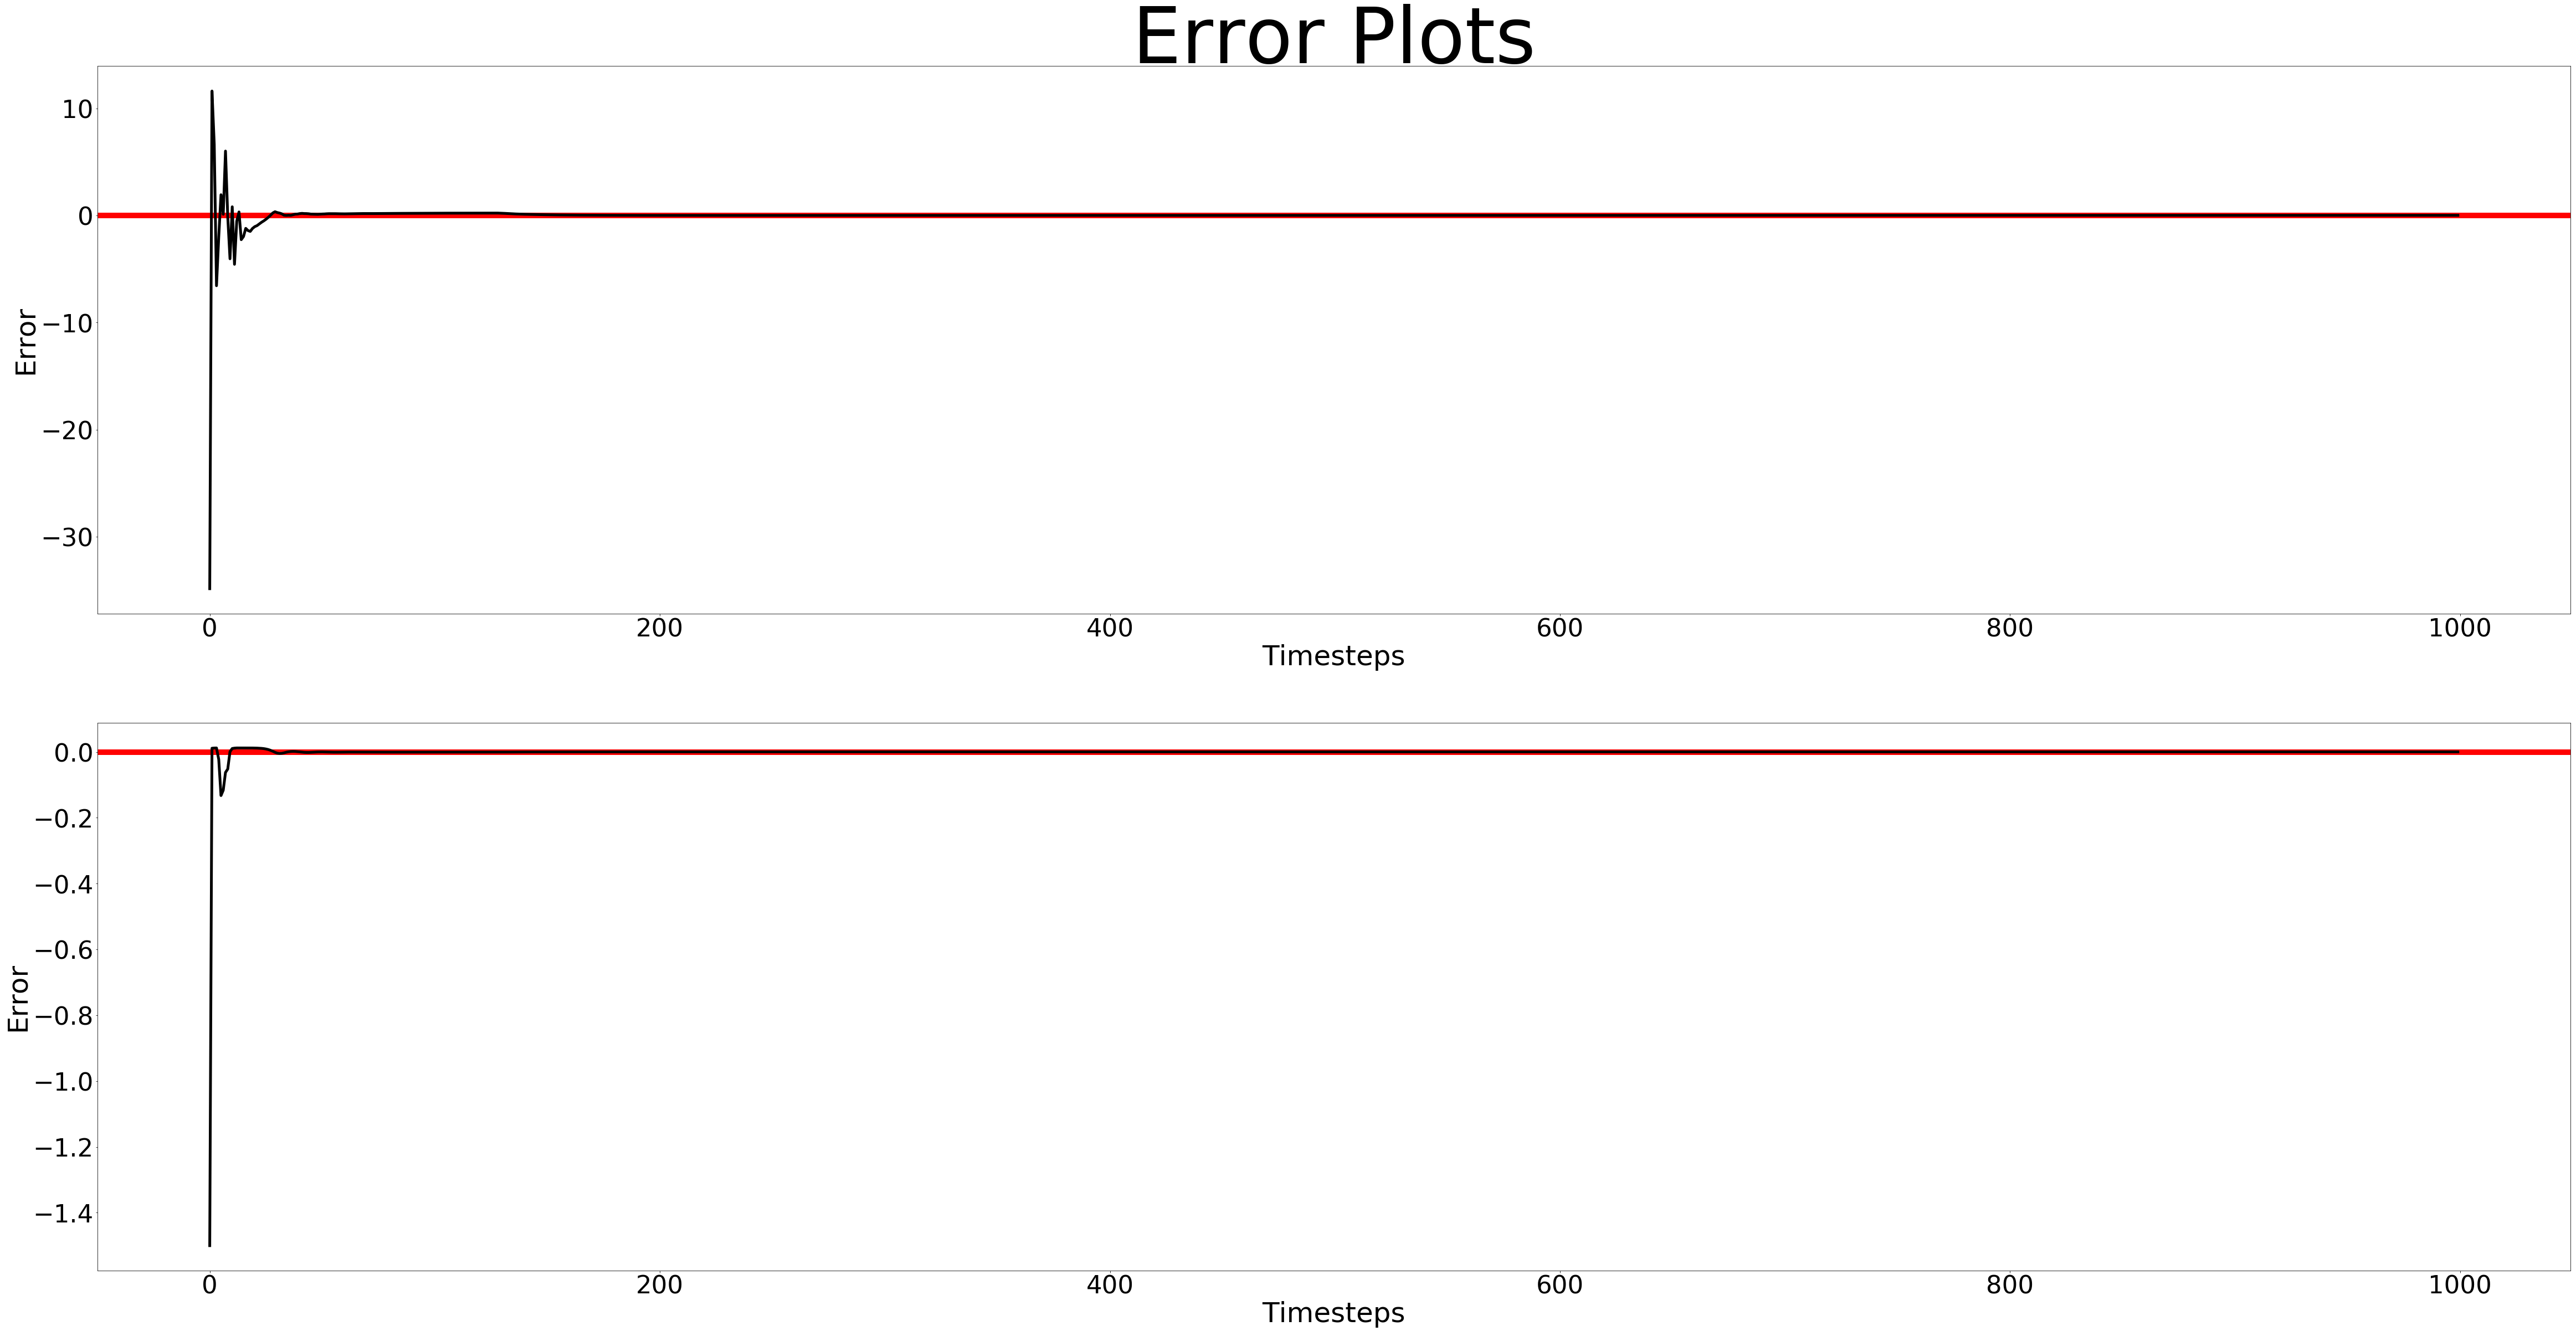

In [7]:
#PLOTTING ERRORS
Errors1 = np.array(Errors1)
Errors2 = np.array(Errors2)
plt.figure(figsize=(80, 40))
plt.subplot(2, 1, 1)
plot_errors(Errors1)
plt.title("Error Plots", fontsize=140, loc='center')
plt.subplot(2, 1, 2)
plot_errors(Errors2)
plt.show()